We now use the asymptotic formula
\begin{equation}
    \tan \delta_0 = \frac{\chi_0(r_2)\sin kr_1 - \chi_0(r_1)\sin kr_2}{\chi_0(r_1)\cos kr_2 − \chi_0(r_2)\cos kr_1},
\end{equation}
where $r_1$ and $r_2$ are two $r$-values in $r > \pi$. It is conventional that $\delta_0$ depends continuously on $k$ and that $\delta_0 \to 0$ as $k \to \infty$.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def potential_U(r, U0):
    if r <= np.pi:
        return -U0 * (1.0 - r / np.pi)**3
    else:
        return 0.0

def schrodinger_derivs(r, y, k, U0):
    chi, chi_prime = y
    dchi_dr = chi_prime
    dchi_prime_dr = -(k**2 - potential_U(r, U0)) * chi
    return [dchi_dr, dchi_prime_dr]

def solve_scattering(k, U0, r_max=10.0, points=1000):
    r_eval = np.linspace(0, r_max, points)
    y0 = [0.0, 1.0] # chi(0) = 0, slope arbitrary

    sol = solve_ivp(
        fun=schrodinger_derivs,
        t_span=(0, r_max),
        y0=y0,
        t_eval=r_eval,
        args=(k, U0),
        method='RK45',
        rtol=1e-9, atol=1e-9
    )
    return sol.t, sol.y[0]

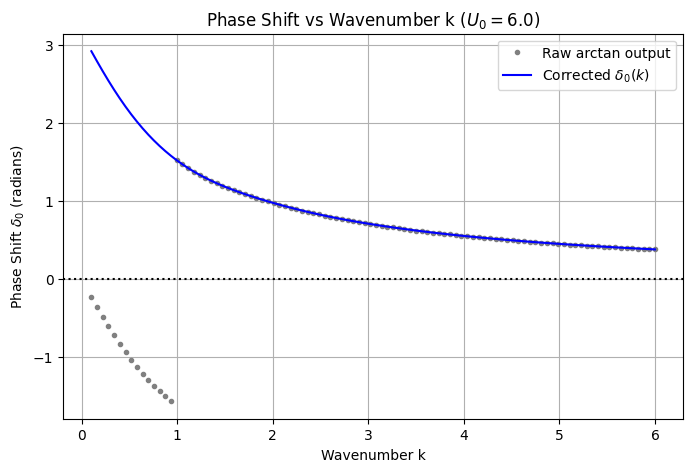

In [9]:
def calculate_delta(r_arr, chi_arr, k):
    '''
    Calculates tan(delta) using two points r1, r2 > pi.
    '''
    # Select two points well outside the potential (r > pi).
    idx2 = -1
    idx1 = -50
    r1, chi1 = r_arr[idx1], chi_arr[idx1]
    r2, chi2 = r_arr[idx2], chi_arr[idx2]

    # Ensure we are outside the potential
    if r1 <= np.pi:
        raise ValueError(f"r1 ({r1}) must be > pi for this formula to hold.")

    numerator = chi2 * np.sin(k * r1) - chi1 * np.sin(k * r2)
    denominator = chi1 * np.cos(k * r2) - chi2 * np.cos(k * r1)
    if abs(denominator) < 1e-10:
        return np.pi/2 * np.sign(numerator)

    tan_delta = numerator / denominator
    return np.arctan(tan_delta)

def investigate_phase_vs_k():
    U0 = 6.0
    k_values = np.linspace(0.1, 6.0, 100) # Range of k
    raw_phases = []

    # Calculate raw phases for each k
    for k in k_values:
        r, chi = solve_scattering(k, U0, r_max=10.0)
        delta_raw = calculate_delta(r, chi, k)
        raw_phases.append(delta_raw)

    raw_phases = np.array(raw_phases)

    # Enforce continuity, unwrap with period pi.
    continuous_phases = np.unwrap(raw_phases, period=np.pi)

    # Enforce asymptotic condition (delta -> 0 as k -> infinity)
    last_val = continuous_phases[-1]
    shift = -np.round(last_val / np.pi) * np.pi
    final_phases = continuous_phases + shift

    plt.figure(figsize=(8, 5))

    plt.plot(k_values, raw_phases, '.', color='gray', label='Raw arctan output')
    plt.plot(k_values, final_phases, '-', color='blue', label=r'Corrected $\delta_0(k)$')

    plt.axhline(0, color='k', linestyle=':')
    plt.title(f"Phase Shift vs Wavenumber k ($U_0={U0}$)")
    plt.xlabel("Wavenumber k")
    plt.ylabel(r"Phase Shift $\delta_0$ (radians)")
    plt.legend()
    plt.grid(True)
    plt.show()

investigate_phase_vs_k()

*   If $r_1$ and $r_2$ are very close, then $\chi(r_1) \approx \chi(r_2)$ and $\sin(kr_1) \approx \sin(kr_2)$. This causes both the numerator and the denominator to approach zero. Computing the ratio of two very small numbers results in a loss of numerical precision due to catastrophic cancellation, leading to noisy or completely incorrect values for $\tan \delta_0$.

*   If the separation corresponds to a specific periodicity $|r_1 - r_2| = n\pi/k$, then the denominator may vanish, causing a singularity where the tangent explodes to infinity. While mathematically valid as it represents a phase of $\pi/2$, numerically this is unstable and undesirable.

*   The asymptotic form $\chi \sim \sin(kr + \delta)$ is only valid where $U(r) = 0$. Using points inside the potential well where $U(r) \neq 0$ would yield a mathematically meaningless result for the scattering phase shift.

Ultimately, we obtain a value for $\tan \delta_0$. The $\arctan$ function is multivalued, returning a result in the principal range $(-\pi/2, \pi/2)$. However, the physical phase shift can be any value so we enforce the convention of continuity by using a numerical unwrapping algorithm (standard in signal processing). Finally, to satisfy the condition $\delta_0 \to 0$ as $k \to \infty$, the entire curve can be adjusted by a constant integer multiple of $\pi$.

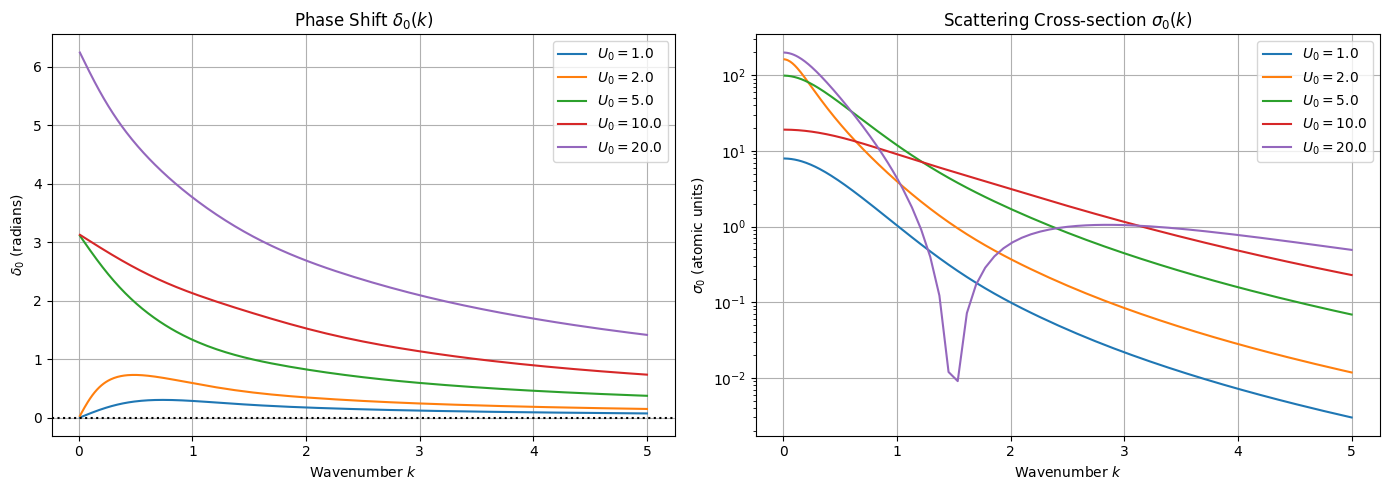

In [15]:
def compute_observables(U0, k_grid):
    '''
    Computes phase shift and cross-section for a full array of k values.
    Handles unwrapping and normalisation.
    '''
    raw_deltas = []

    # Loop over k to get raw phases
    for k in k_grid:
        r, chi = solve_scattering(k, U0)
        delta = calculate_delta(r, chi, k)
        raw_deltas.append(delta)

    raw_deltas = np.array(raw_deltas)

    # Unwrap to enforce continuity
    continuous_deltas = np.unwrap(raw_deltas, period=np.pi)

    # Enforce Convention: delta -> 0 as k -> infinity
    final_val = continuous_deltas[-1]
    shift_amount = -np.round(final_val / np.pi) * np.pi
    final_deltas = continuous_deltas + shift_amount

    # Calculate Cross-section sigma
    # sigma = (4*pi / k^2) * sin^2(delta)
    with np.errstate(divide='ignore', invalid='ignore'):
        sigma = (4 * np.pi / k_grid**2) * np.sin(final_deltas)**2

    return final_deltas, sigma

# Define k grid, dense from 0.01 to 1.0, sparse from 1.0 to 5.0
k_low = np.linspace(0.01, 1.0, 100)
k_high = np.linspace(1.05, 5.0, 50)
k_grid = np.concatenate([k_low, k_high])

U0_values = [1.0, 2.0, 5.0, 10.0, 20.0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for U0 in U0_values:
    deltas, sigma = compute_observables(U0, k_grid)
    ax1.plot(k_grid, deltas, label=f'$U_0 = {U0}$')
    ax2.plot(k_grid, sigma, label=f'$U_0 = {U0}$')

ax1.set_title(r"Phase Shift $\delta_0(k)$")
ax1.set_xlabel(r"Wavenumber $k$")
ax1.set_ylabel(r"$\delta_0$ (radians)")
ax1.axhline(0, color='k', linestyle=':')
ax1.grid(True)
ax1.legend()

ax2.set_title(r"Scattering Cross-section $\sigma_0(k)$")
ax2.set_xlabel(r"Wavenumber $k$")
ax2.set_ylabel(r"$\sigma_0$ (atomic units)")
ax2.set_yscale('log')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

For all $U_0$ and $\delta_0$ approaches 0 as $k \to \infty$. This confirms that high-energy electrons simply pass through the potential with little deflection. However,

*   For small $U_0$, $\delta_0 \to 0$.
*   For large $U_0$, $\delta_0 \to n\pi$.

This is Levinson's theorem, which relates the zero-energy phase shift to the number of bound states $n_b$ supported by the potential $\delta_0(0) = n_b \pi$. The deeper the potential, the higher the phase shift starts at $k=0$.

As $k \to 0$, the cross-section approaches a constant finite value, $\sigma \approx 4\pi a^2$. Note that even though the formula has $1/k^2$, the $\sin^2\delta_0$ term also goes to zero as $k^2$. For $U_0 = 20$, there is a peak where the cross-section varies rapidly. This corresponds to the phase shift passing through $\pi/2$, where $\sin^2 \delta = 1$ and the cross-section reaches its unitarity limit $\sigma_{\max} = 4\pi/k^2$.

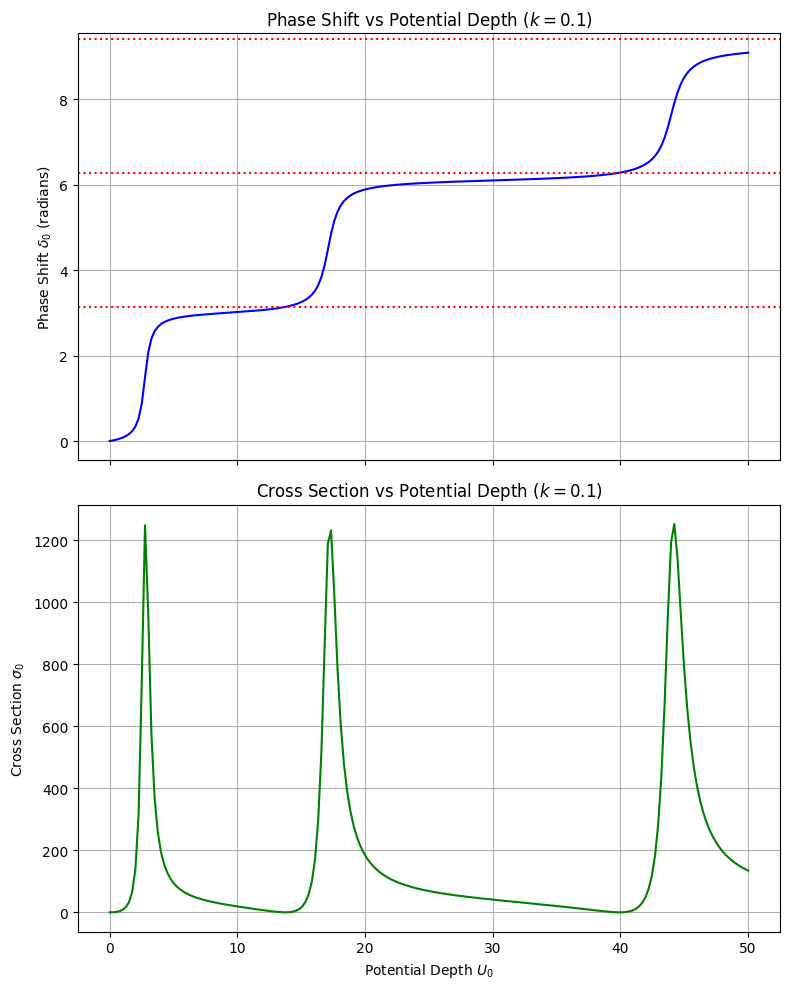

In [21]:
def get_phase_shift(k, U0, r_max=15.0):
    '''
    Solves for a single phase shift delta given k and U0.
    '''
    r_eval = np.linspace(0, r_max, 1000)
    sol = solve_ivp(
        fun=schrodinger_derivs,
        t_span=(0, r_max),
        y0=[0.0, 1.0],
        args=(k, U0),
        method='RK45',
        t_eval=r_eval,
        rtol=1e-9, atol=1e-9
    )

    r = sol.t
    chi = sol.y[0]
    r1, r2 = r[-50], r[-1]
    c1, c2 = chi[-50], chi[-1]

    numerator = c2 * np.sin(k * r1) - c1 * np.sin(k * r2)
    denominator = c1 * np.cos(k * r2) - c2 * np.cos(k * r1)
    if abs(denominator) < 1e-12:
        return np.pi/2 * np.sign(numerator)
    return np.arctan(numerator / denominator)

def investigate_U0_dependence():
    # Parameters
    k_small = 0.1
    U0_range = np.linspace(0, 50, 200)

    raw_phases = []
    for U0 in U0_range:
        delta = get_phase_shift(k_small, U0)
        raw_phases.append(delta)
    raw_phases = np.array(raw_phases)

    phases = np.unwrap(raw_phases, period=np.pi)
    phases = phases - phases[0]
    sigma = (4 * np.pi / k_small**2) * np.sin(phases)**2


    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

    ax1.plot(U0_range, phases, 'b-')
    ax1.set_ylabel(r"Phase Shift $\delta_0$ (radians)")
    ax1.set_title(f"Phase Shift vs Potential Depth ($k={k_small}$)")
    ax1.grid(True)
    for n in range(1, 4):
        ax1.axhline(n * np.pi, color='r', linestyle=':', label=r"$n\pi$" if n==1 else "")

    ax2.plot(U0_range, sigma, 'g-')
    ax2.set_xlabel(r"Potential Depth $U_0$")
    ax2.set_ylabel(r"Cross Section $\sigma_0$")
    ax2.set_title(f"Cross Section vs Potential Depth ($k={k_small}$)")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

investigate_U0_dependence()

As the potential depth $U_0$ increases, the phase shift $\delta_0$ increases monotonically.
*   An attractive potential $U(r) < 0$ increases the kinetic energy of the electron inside the well. Higher kinetic energy implies higher momentum and a shorter de Broglie wavelength inside the potential region.
*   As the wavelength shortens, more nodes of the wavefunction fit inside the potential range $r < \pi$. The external wavefunction is pulled towards the origin to connect continuously with the internal wave, resulting in a positive phase shift.
*   The phase shift passes through integer multiples of $\pi$ as $U_0$ gets larger. According to Levinson's theorem, $\delta_0(k \to 0) = n_b \pi$, where $n_b$ is the number of bound states supported by the potential. Therefore, every time $\delta_0$ increases by $\pi$, the potential has become deep enough to support one additional bound state.


The cross-section $\sigma$ exhibits drastic peaks as $U_0$ increases.

*   The peaks occur when the phase shift is a half-integer multiple of $\pi$ or $\delta_0 \approx \pi(n + \frac{1}{2})$. At these points, $\sin^2 \delta_0 = 1$, and the scattering is maximal with $\sigma_{\max} = 4\pi/k^2$. This corresponds to a resonance where the incident electron is temporarily trapped in a virtual state inside the potential well, interacting strongly before scattering.
*   The minima (zeros) occur when the phase shift is an integer multiple of $\pi$ or $\delta_0 \approx n\pi$. At these points, $\sin^2 \delta_0 = 0$, and the cross-section drops to nearly zero. The wavefunction outside the potential looks like the free particle wavefunction since $\sin(kr + n\pi) = \pm \sin(kr)$. This is a quantum mechanical transparency effect where the target becomes effectively invisible to the electron beam. Since these minima occur at $\delta_0 = n\pi$, they coincide with the threshold where a new bound state.

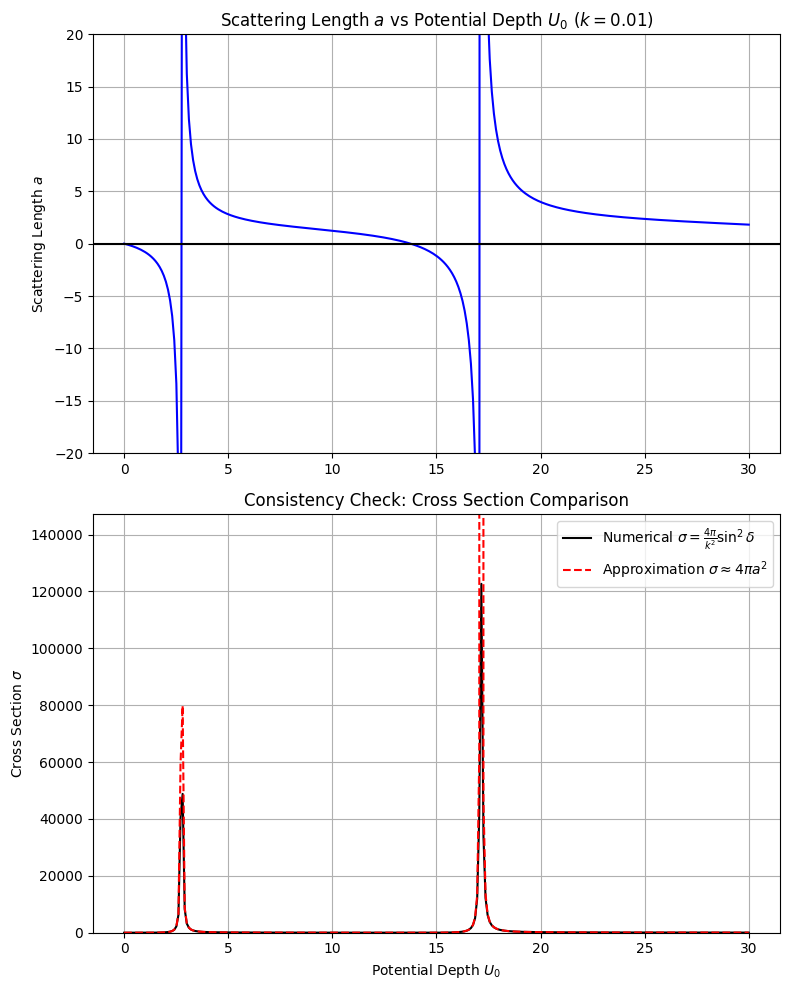

In [23]:
def analyze_scattering_length():
    k_test = 0.01
    U0_values = np.linspace(0, 30, 300)

    a_values = []
    sigma_numerical = []
    sigma_approx = []

    for U0 in U0_values:
        delta = get_phase_shift(k_test, U0)
        # Scattering length
        # Formula: a = - tan(delta) / k
        a = -np.tan(delta) / k_test
        a_values.append(a)

        # Cross sections numerical result
        # sigma = (4pi / k^2) * sin^2(delta)
        sig_num = (4 * np.pi / k_test**2) * np.sin(delta)**2
        sigma_numerical.append(sig_num)

        # Theoretical Approximation (using a)
        # sigma = 4 * pi * a^2
        sig_app = 4 * np.pi * a**2
        sigma_approx.append(sig_app)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

    ax1.plot(U0_values, a_values, 'b-')
    ax1.set_title(f"Scattering Length $a$ vs Potential Depth $U_0$ ($k={k_test}$)")
    ax1.set_ylabel("Scattering Length $a$")
    ax1.grid(True)
    ax1.set_ylim(-20, 20)
    ax1.axhline(0, color='k')

    ax2.plot(U0_values, sigma_numerical, 'k-', label=r"Numerical $\sigma = \frac{4\pi}{k^2}\sin^2\delta$")
    ax2.plot(U0_values, sigma_approx, 'r--', label=r"Approximation $\sigma \approx 4\pi a^2$")

    ax2.set_title("Consistency Check: Cross Section Comparison")
    ax2.set_xlabel("Potential Depth $U_0$")
    ax2.set_ylabel(r"Cross Section $\sigma$")
    ax2.legend()
    ax2.grid(True)
    ax2.set_ylim(0, 1.2 * max(sigma_numerical))

    plt.tight_layout()
    plt.show()

analyze_scattering_length()

he scattering length $a$ for small $k$ is given by
\begin{equation}
    a \approx -\frac{\tan \delta_0(k)}{k}.
\end{equation}
Note that $a$ diverges to $\pm \infty$ at specific values of $U_0$. These divergences correspond to resonances where a new bound state appears in the potential well given by Levinson's theorem.

For most values of $U_0$, the scattering length $a$ is the correct parameter to characterise the scattering at low energies. At the specific $U_0$ values where resonances occur ($\delta_0 = \pi/2, 3\pi/2 \dots$), the scattering length $a \to \infty$, so the approximation $\sigma \approx 4\pi a^2$ diverges to infinity. However, the physical cross-section is bounded by the unitarity limit
\begin{equation}
    \sigma_{\max} = \frac{4\pi}{k^2}.
\end{equation}
The relation $\sigma = 4\pi a^2$ is only valid when $k|a| \ll 1$. Near a resonance, $a$ becomes very large, violating this condition even for small $k$. Away from these singularities, the agreement is excellent.